In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
# from small_script.myFunctions import *
from Bio.PDB.Polypeptide import three_to_one


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['figure.figsize'] = [16.18033, 10]    #golden ratio
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.dpi'] = 100

In [188]:
data = pd.read_csv("/Users/weilu/Research/database/membrane_training_set/proteins-2019-05-01.csv")
data.pdbid = data.pdbid.apply(lambda x: x[2:-1])

In [189]:
data.shape

(4384, 31)

In [190]:
data.columns

Index(['id', 'ordering', 'family_name_cache', 'species_name_cache',
       'membrane_name_cache', 'name', 'description', 'comments', 'pdbid',
       'resolution', 'topology_subunit', 'topology_show_in', 'thickness',
       'thicknesserror', 'subunit_segments', 'tilt', 'tilterror', 'gibbs',
       'tau', 'verification', 'membrane_id', 'species_id', 'family_id',
       'superfamily_id', 'classtype_id', 'type_id',
       'secondary_representations_count', 'structure_subunits_count',
       'citations_count', 'created_at', 'updated_at'],
      dtype='object')

In [204]:
t = data[["pdbid", "structure_subunits_count", "secondary_representations_count", "subunit_segments", "resolution", "citations_count"]]


In [208]:
t.query("subunit_segments==1 and resolution !='NMR'").sort_values("resolution")

,pdbid,structure_subunits_count,secondary_representations_count,subunit_segments,resolution,citations_count
218,2xfn,1,5,1,1.6,0
1204,2hil,1,0,1,12.5,0
1205,1oqw,1,8,1,2.00,0
2921,4rwb,1,1,1,2.00,0
2328,4wmz,1,27,1,2.05,0
2530,5eqb,1,0,1,2.19,0
801,2z5x,1,3,1,2.2,0
1719,3sok,1,0,1,2.30,0
1941,3vmt,1,3,1,2.30,0
3075,5jlc,1,0,1,2.4,0


In [5]:
data.head()

,id,ordering,family_name_cache,species_name_cache,membrane_name_cache,name,description,comments,pdbid,resolution,...,species_id,family_id,superfamily_id,classtype_id,type_id,secondary_representations_count,structure_subunits_count,citations_count,created_at,updated_at
0,1,2024.0,OmpA family,Escherichia coli,Gram-neg. outer,"Outer membrane protein A (OMPA), disordered loops",NaN,OmpA is required for the action of colicins K ...,1qjp,1.65,...,9,34,26,2,1,3,1,2,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
1,2,2028.0,Enterobacterial Ail/Lom protein,Escherichia coli,Gram-neg. outer,Outer membrane protein X (OMPX),NaN,OmpX from Escherichia coli promotes adhesion t...,1qj8,1.90,...,9,355,26,2,1,7,1,1,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
2,3,2033.0,Opacity porins,Neisseria meningitidis,Gram-neg. outer,Outer membrane protein NspA,NaN,Pathogenic Neisseria spp. possess a repertoire...,1p4t,2.55,...,24,337,235,2,1,0,1,0,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC
3,4,1740.0,Influenza virus matrix protein 2,Influenza virus,Viral,"M2 proton channel of Influenza A, closed state...",NaN,NaN,3lbw,1.65,...,51,263,185,11,1,3,4,0,2018-08-13 03:49:46 UTC,2018-10-02 17:42:36 UTC
4,5,2045.0,"OM protease omptin, OMPT",Yersinia pestis,Gram-neg. outer,Plasminogen activator PLA (coagulase/fibrinoly...,NaN,NaN,2x55,1.85,...,299,36,27,2,1,2,1,0,2018-08-13 03:49:46 UTC,2018-09-21 18:14:03 UTC


In [6]:
data.query("classtype_id == 1")["superfamily_id"].unique().shape

(120,)

In [7]:
data.query("classtype_id == 1").shape

(1593, 31)

# class 1 is Alpha-helical polytopic

In [8]:
d = data.query("classtype_id == 1")

In [23]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
def get_inside_or_not_table(structure):
    inside_or_not_table = []
    for res in structure.get_residues():
        if res.get_id()[0] != " ":
            continue# skip
        try:
            res["CA"].get_vector()
        except:
            print(structure, res.get_full_id())
            continue
        inside_or_not_table.append(int(abs(res["CA"].get_vector()[-1]) < 15))
    return inside_or_not_table

In [24]:
from Bio.PDB import Select
from Bio.PDB import PDBIO
class NormalResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_id()[0] == ' ' and residue.has_id("CA"):
            return 1
        else:
            return 0



# clean the pdbs first

In [25]:
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
pdb_list = d.pdbid.tolist()
parser = PDBParser(PERMISSIVE=1,QUIET=True)
io = PDBIO()
_info = []
count = 0
for pdb in pdb_list:
    if count % 100 == 0:
        print(count, pdb)
    count += 1
    location = pre + f"../Alpha-helical_polytopic/{pdb}.pdb"
    try:
        structure = parser.get_structure(pdb, location)
    except:
        print("cannot get ", pdb)
        continue
#     a = get_inside_or_not_table(structure)
#     ratio = sum(a)/len(a)
    io.set_structure(structure)
    io.save(f'{pre}/cleaned/{pdb}.pdb', NormalResSelect())
#     _info.append([pdb, len(a), ratio])

0 1ots
100 3hzq
200 3blc
300 4ayt
400 4hg6
500 4lep
600 4o6m
cannot get  6dhe
cannot get  4v7i
700 4x2s
800 3jc2
900 5kli
cannot get  5gup
1000 5xan
cannot get  5xnl
1100 5u74
cannot get  6ftj
cannot get  6ftg
1200 5zf0
cannot get  5zf0
cannot get  6oeu
1300 6fnp
cannot get  6jpf
cannot get  3j7q
cannot get  3j7r
1400 3kp9
1500 6n4i
cannot get  5oqk
cannot get  5zmw
cannot get  6iok
cannot get  6nsj
cannot get  6nsk
cannot get  6mi7
cannot get  6mi8
cannot get  6mhu
cannot get  6mhz
cannot get  6m97
cannot get  6mct
cannot get  6mpw
cannot get  6o7t
cannot get  6o7u


In [26]:
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
pdb_list = d.pdbid.tolist()
parser = PDBParser(PERMISSIVE=1,QUIET=True)
io = PDBIO()
_info = []
count = 0
for pdb in pdb_list:
    if count % 100 == 0:
        print(count, pdb)
    count += 1
    location = f'{pre}/cleaned/{pdb}.pdb'
    try:
        structure = parser.get_structure(pdb, location)
    except:
        print("cannot get ", pdb)
        continue
    a = get_inside_or_not_table(structure)
    ratio = sum(a)/len(a)
#     io.set_structure(structure)
#     io.save(f'{pre}/cleaned/{pdb}.pdb', NormalResSelect())
    _info.append([pdb, len(a), ratio])

0 1ots
100 3hzq
200 3blc
300 4ayt
400 4hg6
500 4lep
600 4o6m
cannot get  6dhe
cannot get  4v7i
700 4x2s
800 3jc2
cannot get  5gky
cannot get  5gkz
cannot get  5gl0
cannot get  5gl1
cannot get  5go9
cannot get  5goa
900 5kli
cannot get  5gup
1000 5xan
cannot get  5xti
cannot get  5xnl
1100 5u74
cannot get  6ftj
cannot get  6ftg
1200 5zf0
cannot get  5zf0
cannot get  6oeu
1300 6fnp
cannot get  6jpf
cannot get  3j7q
cannot get  3j7r
1400 3kp9
1500 6n4i
cannot get  5oqk
cannot get  5zmw
cannot get  6iok
cannot get  6nsj
cannot get  6nsk
cannot get  6mi7
cannot get  6mi8
cannot get  6mhu
cannot get  6mhz
cannot get  6m97
cannot get  6mct
cannot get  6mpw
cannot get  6o7t
cannot get  6o7u


In [27]:
info = pd.DataFrame(_info, columns=["Protein", "Length", "InMembraneRatio"])

,Protein,Length,InMembraneRatio
0,1ots,885,0.737853
1,3pl9,156,0.647436
2,1kpl,881,0.748014
3,1yew,2424,0.340347
4,2oau,1778,0.151294
5,2oar,625,0.401600
6,2o9g,932,0.751073
7,1ldf,1016,0.688976
8,1u7g,1149,0.710183
9,2b6p,1044,0.666667


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bb27ef0>]],
      dtype=object)

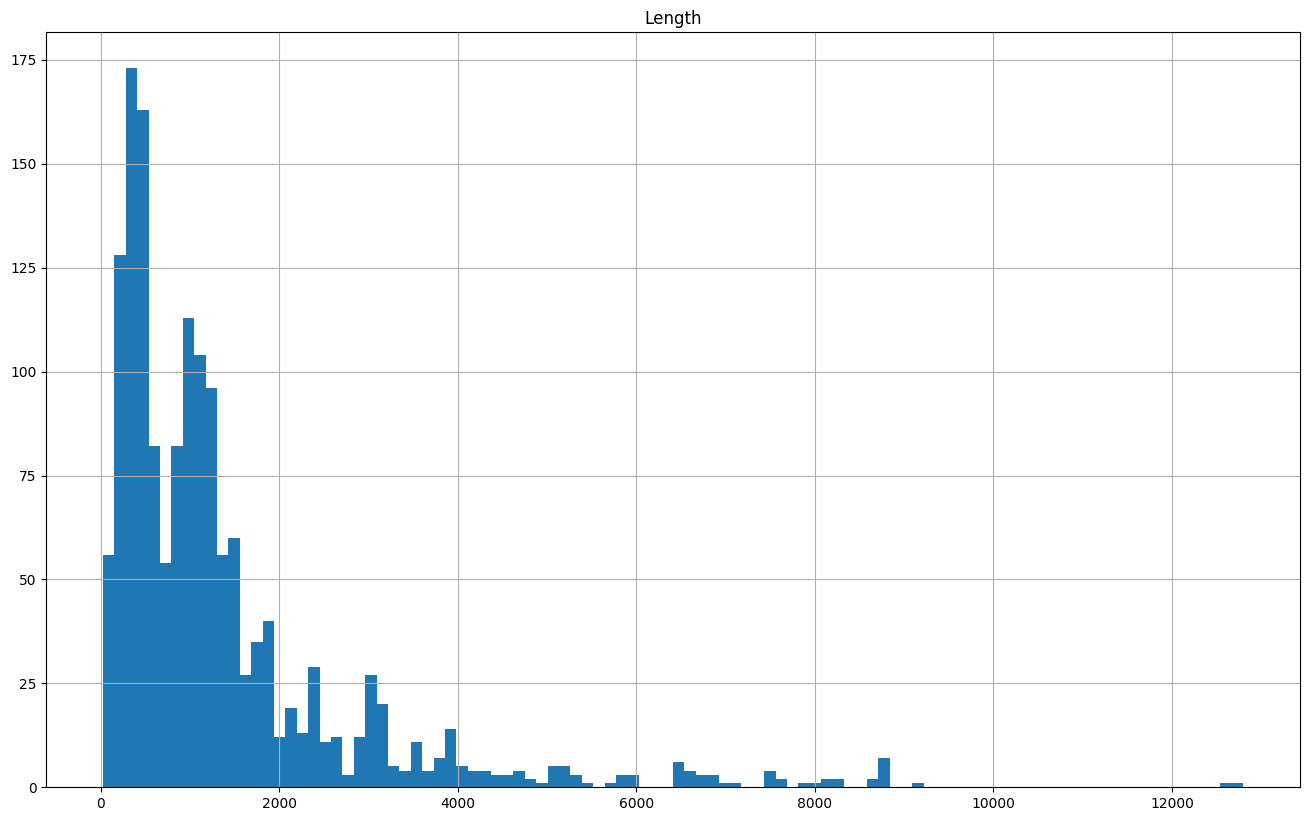

In [30]:
info.hist("Length", bins=100)

In [32]:
info.sort_values("Length").query("Length < 2000").shape

(1273, 3)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1d0356d8>]],
      dtype=object)

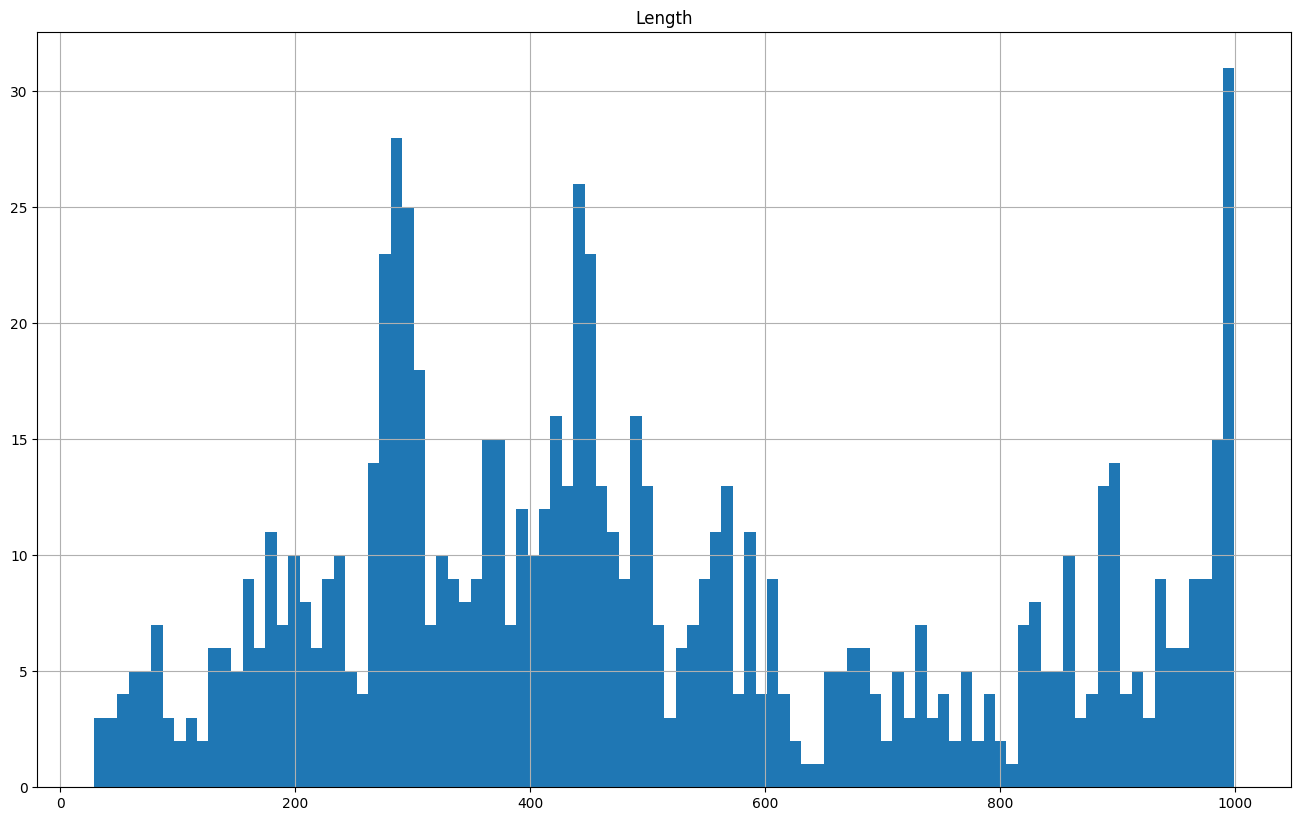

In [78]:
info.query("Length < 1000").hist("Length", bins=100)

In [79]:
info.sort_values("Length").query("Length < 1000").shape

(825, 3)

In [80]:
info.sort_values("Length").query("Length < 800").shape

(658, 3)

In [81]:
info.sort_values("Length").query("Length < 800").tail()

,Protein,Length,InMembraneRatio
835,5doq,792,0.542929
15,1lgh,792,0.424242
536,3waj,793,0.360656
877,5l25,798,0.655388
1286,5zov,798,0.769424


In [82]:
info.sort_values("Length").query("Length < 800").head()

,Protein,Length,InMembraneRatio
1177,2k8j,29,0.862069
95,1rkl,31,0.903226
96,2lat,35,0.742857
470,2lzr,44,0.636364
827,2n7r,46,0.434783


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a22e100b8>]],
      dtype=object)

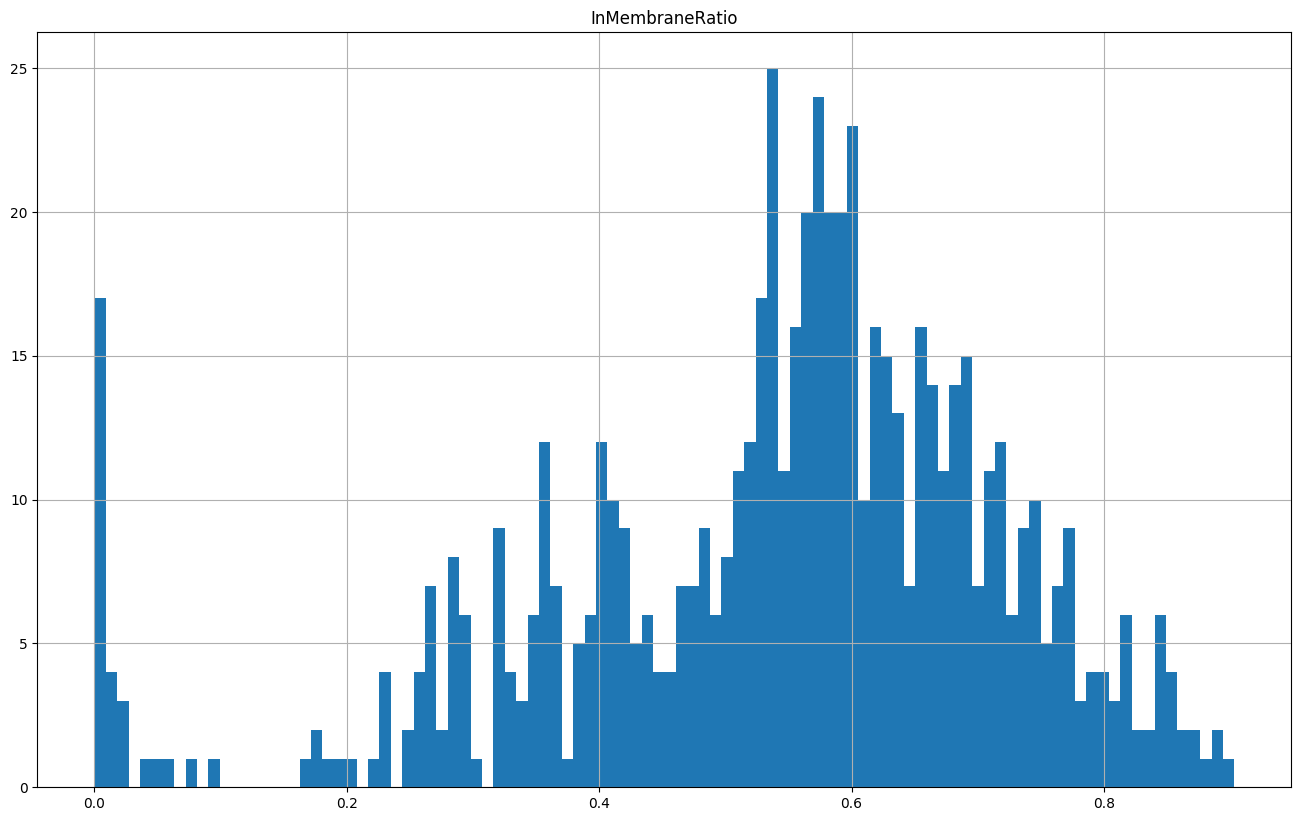

In [83]:
info.sort_values("Length").query("Length < 800").hist("InMembraneRatio", bins=100)

In [136]:
info.to_csv("/Users/weilu/Research/database/membrane_contact_dtabase/for_iter0_training_complete_jun06.csv")


In [144]:
membrane_contact_chosen = info.query("InMembraneRatio > 0.5 and Length < 1000").reset_index()
membrane_contact_chosen.to_csv("/Users/weilu/Research/database/membrane_contact_dtabase/for_iter0_training_jun06.csv")




# I will use 800 as cutoff. So the database I will be using contains 658 proteins.

In [86]:
chosen = info.sort_values("Length").query("Length < 800").reset_index()

In [88]:
chosen.to_csv("/Users/weilu/Research/database/hybrid_contact_database/for_iter0_training_jun06.csv")

In [112]:
chosen = pd.read_csv("/Users/weilu/Research/database/hybrid_contact_database/for_iter0_training_jun06.csv", index_col=0)
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
toPre = "/Users/weilu/Research/server/jun_2019/membrane_contact_optimization/database/"
pdb_list = chosen.Protein.tolist()
for pdb in pdb_list:
    fromLocation = f'{pre}/cleaned/{pdb}.pdb'
    toLocation = f"{toPre}/dompdb/"
    os.system(f"cp {fromLocation} {toLocation}")
#     seq = ""
#     for res in structure.get_residues():
#         resName = three_to_one(res.resname)
#         seq += resName
#     with open(f"{toPre}/S20_seq/{pdb}.seq", "w") as out:
#         out.write(seq+"\n")


In [182]:
chosen = pd.read_csv("/Users/weilu/Research/database/hybrid_contact_database/for_iter0_training_jun06.csv", index_col=0)
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
toPre = "/Users/weilu/Research/server/jun_2019/membrane_contact_optimization/database/"
pdb_list = chosen.Protein.tolist()
for pdb in pdb_list:
    fromLocation = f'{pre}/cleaned/{pdb}.pdb'
#     toLocation = f"{toPre}/dompdb/"
#     os.system(f"cp {fromLocation} {toLocation}")
    try:
        structure = parser.get_structure(pdb, fromLocation)
    except:
        print("cannot get ", pdb)
        continue
    seq = ""
    for res in structure.get_residues():
        resName = three_to_one(res.resname)
        seq += resName
    with open(f"{toPre}/S20_seq/{pdb}.seq", "w") as out:
        out.write(seq+"\n")


In [111]:
with open(f"{toPre}..//optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        out.write(pdb+"\n")

In [109]:
np.random.shuffle(pdb_list)

In [128]:
len(pdb_list)

658

# membrane contact

In [148]:
from small_script.myFunctions import *

In [152]:
chosen = pd.read_csv("/Users/weilu/Research/database/membrane_contact_dtabase/for_iter0_training_jun06.csv", index_col=0)
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
toPre = "/Users/weilu/Research/database/membrane_contact_dtabase/"
pdb_list = chosen.Protein.tolist()
for pdb in pdb_list:
    fromLocation = f'{pre}/cleaned/{pdb}.pdb'
    toLocation = f"{toPre}/dompdb/{pdb}.pdb"
#     os.system(f"cp {fromLocation} {toLocation}")
    try:
        extractTransmembrane(toLocation, fromLocation)
    except:
        print(pdb)
        pass

In [181]:
pre = "/Users/weilu/Research/server/jun_2019/membrane_only_contact_optimization/database"
toPre = "/Users/weilu/Research/server/jun_2019/membrane_only_contact_optimization/database"
for pdb in pdb_list:
    fromLocation = f'{pre}/dompdb/{pdb}.pdb'
#     os.system(f"cp {fromLocation} {toLocation}")
    try:
        structure = parser.get_structure(pdb, fromLocation)
    except:
        print("cannot get ", pdb)
        continue
    seq = ""
    for res in structure.get_residues():
        resName = three_to_one(res.resname)
        seq += resName
    with open(f"{toPre}/S20_seq/{pdb}.seq", "w") as out:
        out.write(seq+"\n")

In [157]:
np.random.shuffle(pdb_list)
with open(f"/Users/weilu/Research/server/jun_2019/membrane_only_contact_optimization/optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        out.write(pdb+"\n")

In [158]:
len(pdb_list)

533

In [174]:

data = get_MSA_data("/Users/weilu/Research/server/jun_2019/MSA/1a91.a3m")
with open("/Users/weilu/Research/server/jun_2019/membrane_only_contact_optimization/multiSeq/alignments/1a91.seqs", "w") as out:
    for line in data:
        out.write(line+"\n")

In [ ]:
pre = "/Users/weilu/Research/server/may_2019/four_body_helix_large_data/database/"
for pdb in pdb_list:
    toLocation = pre + f"dompdb/{pdb}.pdb"
    location = pre + f"cleaned_pdbs/{pdb}.pdb"
    try:
        extractTransmembrane(toLocation, location)
    except:
        pass

In [184]:
[1, 2] * 2

[1, 2, 1, 2]

In [186]:
(100//3+1)

33

In [52]:
eta_switching = "eta_switching"
membrane_center = "membrane_center"
z_m = "z_m"
f"0.5*tanh({eta_switching}*((z-{membrane_center})+{z_m}))+0.5*tanh({eta_switching}*({z_m}-(z-{membrane_center})))"

'0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center)))'

In [124]:
eta_switching = 2
membrane_center = 0
z_m = 15
z = np.linspace(-20,20, 1000)
tanh = np.tanh

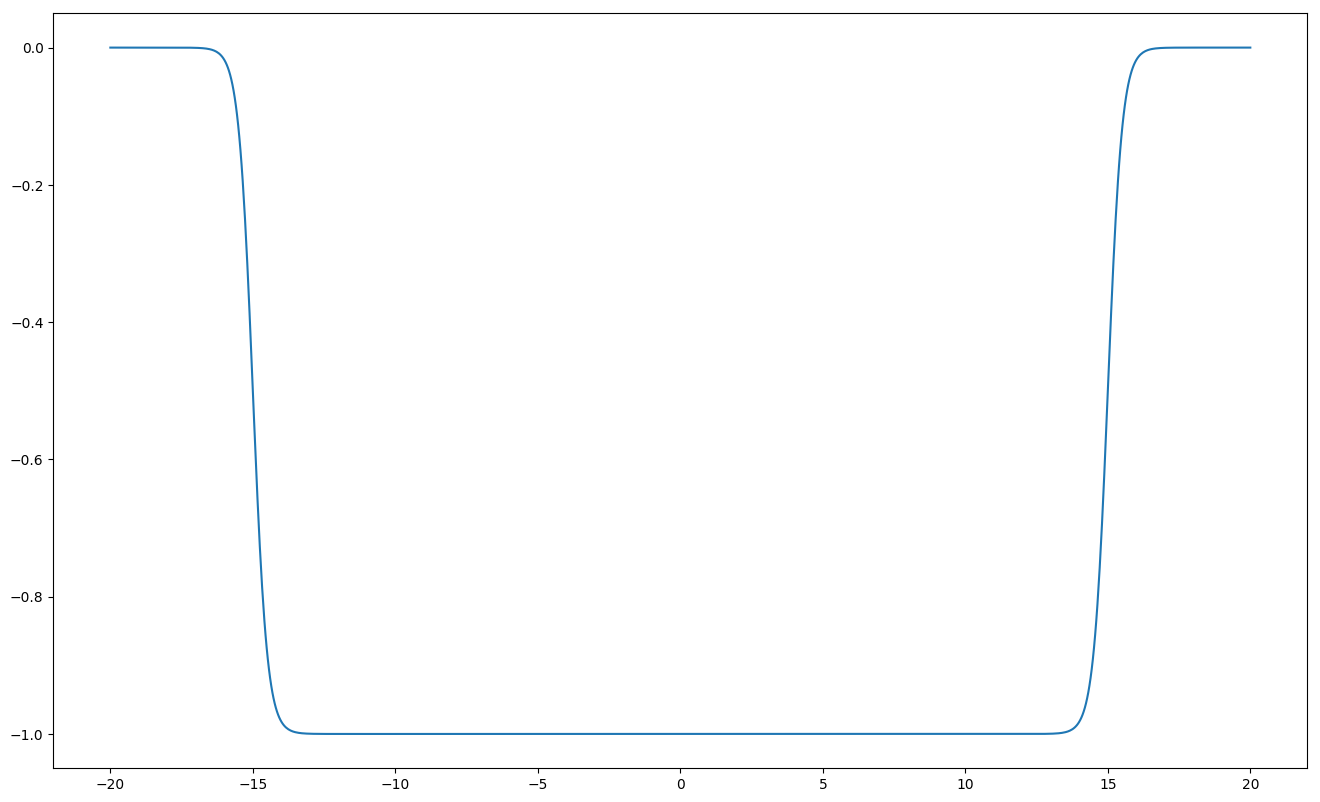

In [160]:
y1 = -(0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center))))
plt.plot(z, y1)

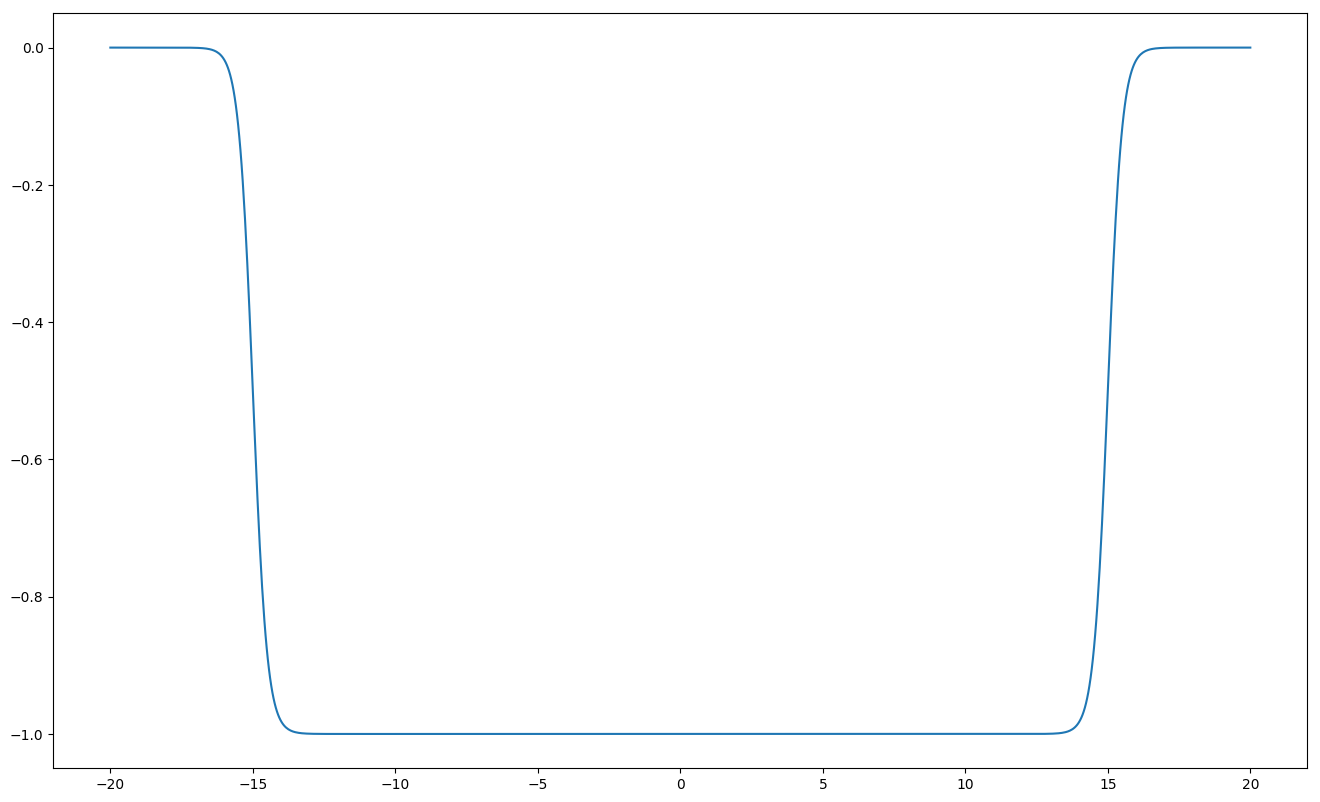

In [172]:
y1 = -(0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center))) -0.5) -0.5
plt.plot(z, y1)

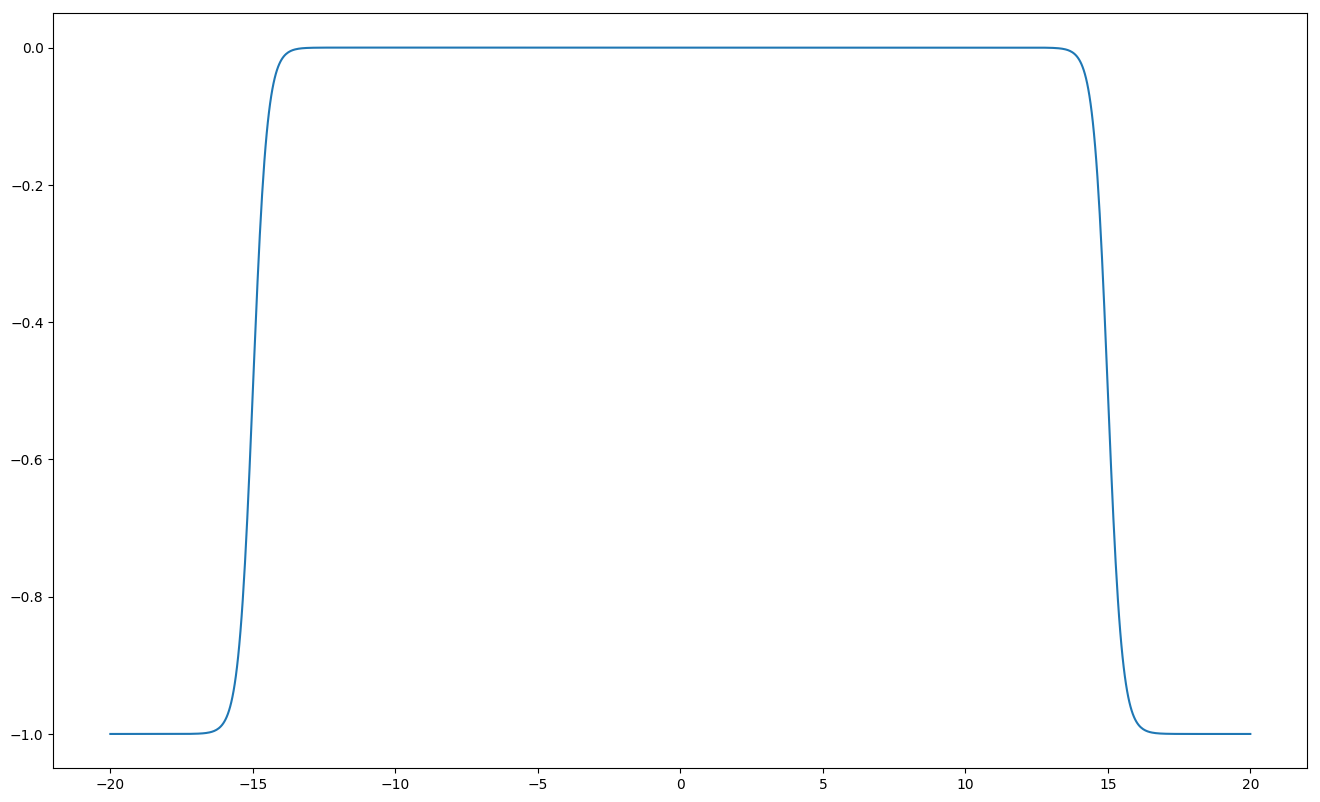

In [171]:
y1 = (0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center))) -0.5) -0.5
plt.plot(z, y1)

(-20, -10)

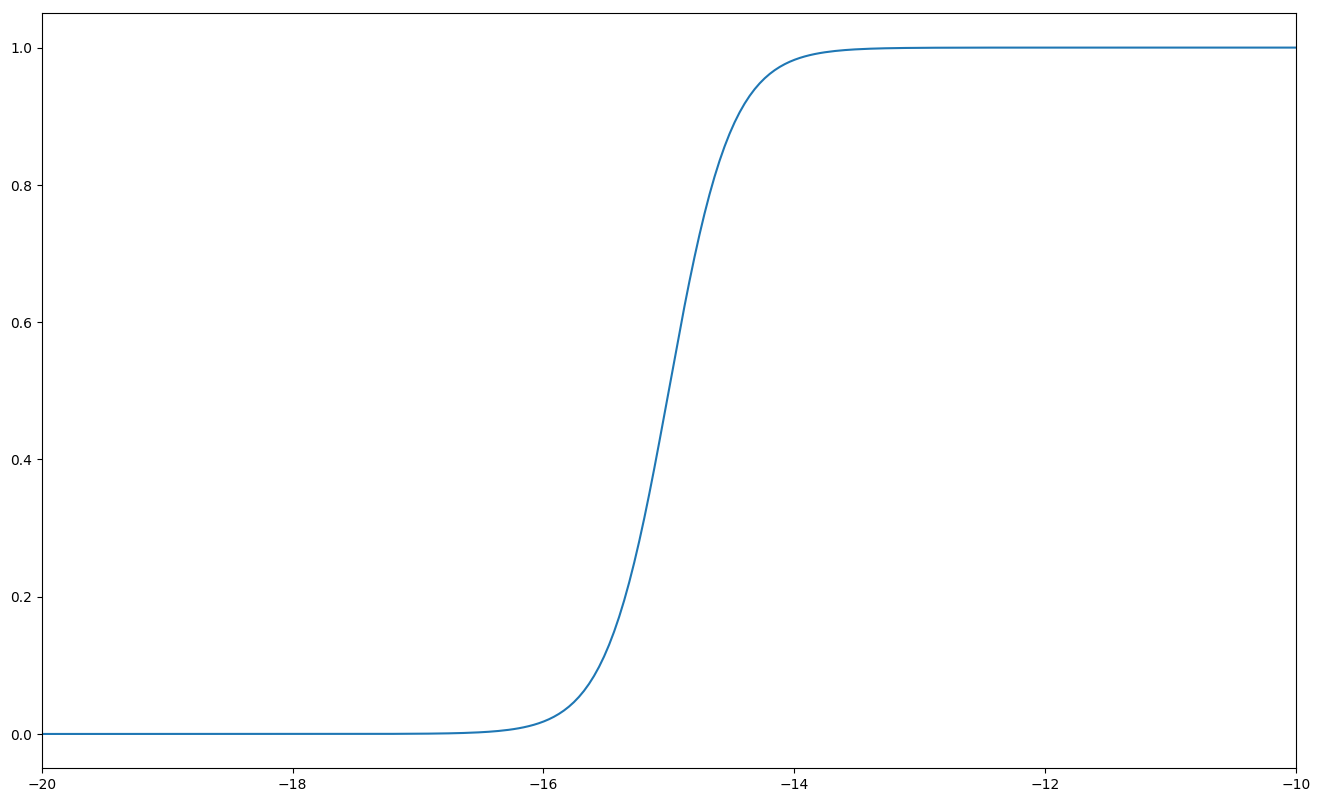

In [126]:
y1 = 0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center)))
plt.plot(z, y1)
plt.xlim(-20, -10)

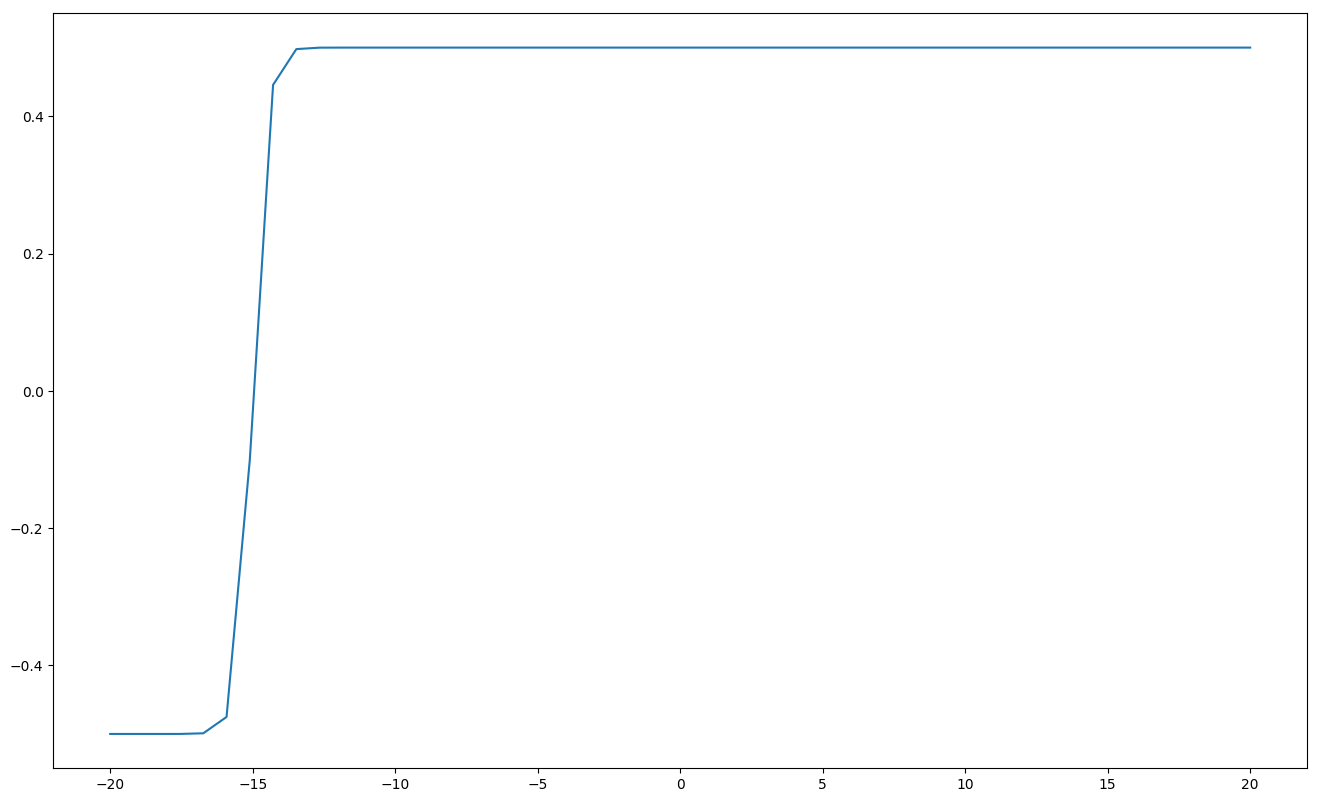

In [122]:
y1 = 0.5*tanh(eta_switching*((z-membrane_center)+z_m))
plt.plot(z, y1)

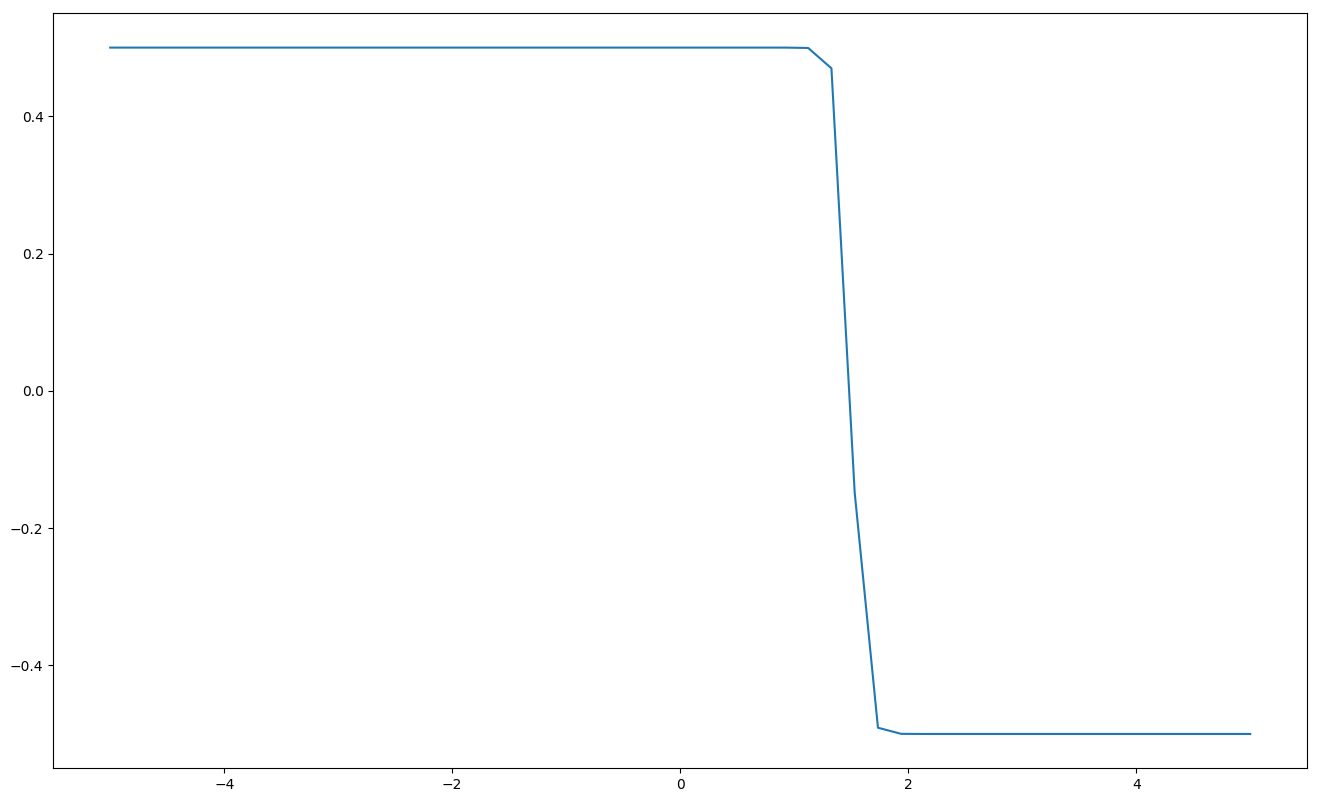

In [59]:
y2 = 0.5*tanh(eta_switching*(z_m-(z-membrane_center)))
plt.plot(z, y2)

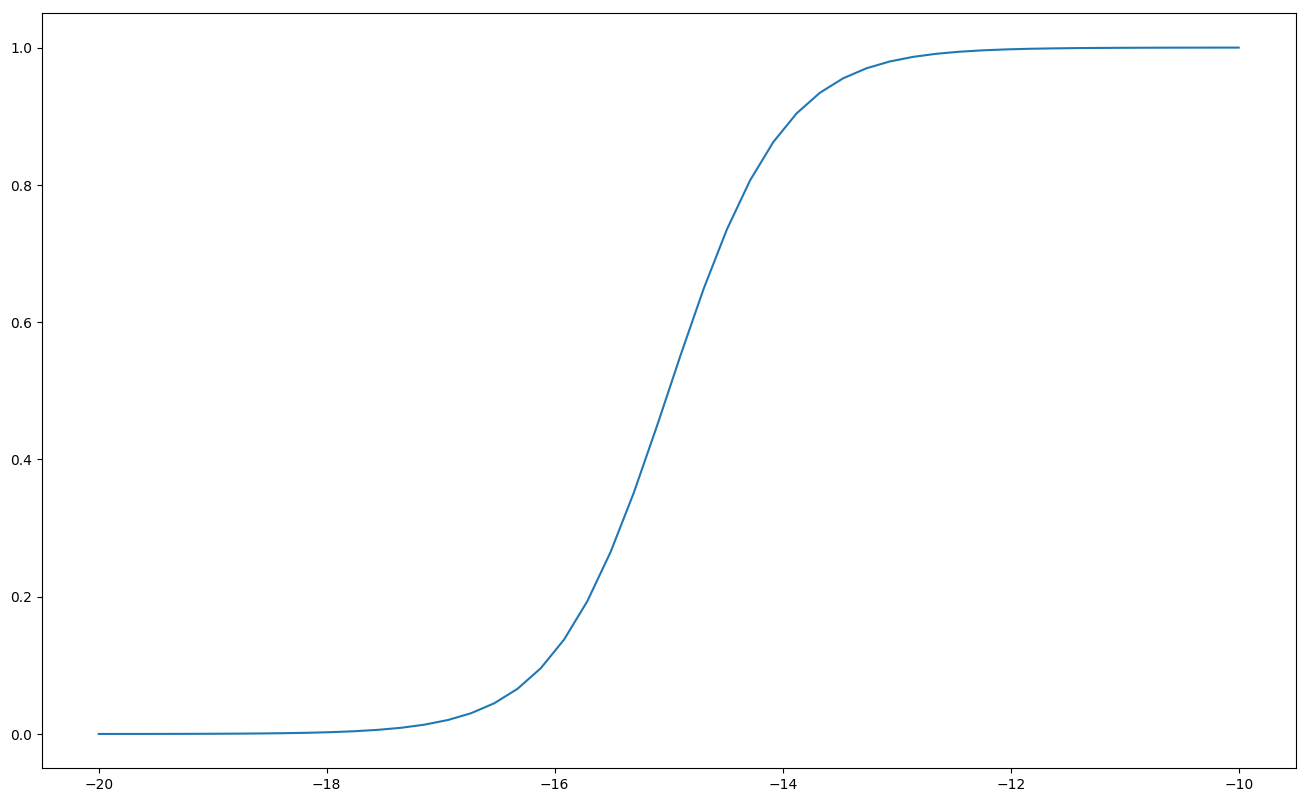

In [74]:
z = np.linspace(-20,-10)
y = 0.5*tanh(eta_switching*((z-membrane_center)+z_m))+0.5*tanh(eta_switching*(z_m-(z-membrane_center)))
plt.plot(z,y)

In [27]:
dd = d.groupby("superfamily_id").apply(pd.DataFrame.sample, 1).reset_index(drop=True)

In [32]:
dd.to_csv("/Users/weilu/Research/database/membrane_training_set/chosen.csv")

In [ ]:
pre = "/Users/weilu/Research/database/hybrid_contact_database/"
pdb_list = d.pdbid.tolist()
parser = PDBParser(PERMISSIVE=1,QUIET=True)
for pdb in pdb_list[:10]:
#     location = f"{pre}/cleaned/{pdb}.pdb"
    location = pre + f"../Alpha-helical_polytopic/{pdb}.pdb"
    try:
        structure = parser.get_structure('X', location)
    except:
        print("cannot get ", pdb)
        continue
    print(len(a))
    a = get_inside_or_not_table(structure)
    ratio = sum(a)/len(a)
    if ratio < 0.4:
        print("not good", pdb, ratio)
    print(pdb, ratio)

In [137]:
dd.shape

(120, 31)

In [28]:
test = dd.sample(10)

In [31]:
print(test.pdbid.tolist())

['6c70', '5azb', '6mlu', '4r1i', '6bvg', '4zr1', '5o5e', '1lv7', '6eu6', '4pgr']


In [ ]:
pd.DataFrame.sample

In [9]:
t = data["superfamily_id"]

In [ ]:
t.unique()

In [ ]:
pdb_list = dd.pdbid.tolist()
for pdb in pdb_list:
    location = pre + f"../Alpha-helical_polytopic/{pdb}.pdb"
    a = get_inside_or_not_table(location)
    ratio = sum(a)/len(a)
    if ratio < 0.4:
        print("not good", pdb, ratio)
    print(pdb, ratio)

# extract transmembrane region.

In [10]:
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.Polypeptide import PPBuilder
def get_inside_or_not_table(pdb_file):
    parser = PDBParser(PERMISSIVE=1,QUIET=True)
    try:
        structure = parser.get_structure('X', pdb_file)
    except:
        return [0]
    inside_or_not_table = []
    for res in structure.get_residues():
        if res.get_id()[0] != " ":
            continue# skip
        try:
            res["CA"].get_vector()
        except:
            print(pdb_file, res.get_id())
            continue
        inside_or_not_table.append(int(abs(res["CA"].get_vector()[-1]) < 15))
    return inside_or_not_table

In [11]:
parser = PDBParser(PERMISSIVE=1,QUIET=True)
pdb_file = "/Users/weilu/Research/database/Alpha-helical_polytopic/3b9y.pdb"
structure = parser.get_structure('X', pdb_file)

In [12]:
a = list(structure.get_residues())

In [13]:
len(a)

3879

In [14]:
r = a[0]

In [22]:
r.has_id("CA")

True

In [19]:
list(r.get_atoms())

[<Atom N>,
 <Atom CA>,
 <Atom C>,
 <Atom O>,
 <Atom CB>,
 <Atom CG>,
 <Atom CD>,
 <Atom OE1>,
 <Atom OE2>]

In [39]:
r.get_full_id()

('X', 0, 'A', (' ', 31, ' '))

# get information about seq len. and remove nonwanted atom.

In [17]:
from Bio.PDB import Select
from Bio.PDB import PDBIO
class NormalResSelect(Select):
    def accept_residue(self, residue):
        if residue.get_id()[0] == ' ':
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(structure)
io.save('/Users/weilu/Research/server/jun_2019/membrane_contact_optimization/clean.pdb', NormalResSelect())

In [30]:
t = "sdfdf\n".strip()

In [40]:
from Bio.PDB import Selection

In [38]:
tt = []
tt.append(t)
tt.append(t)

In [39]:
tt

['sdfdf', 'sdfdf']

In [20]:
r.get_id()

('H_DUM', 1477, ' ')

In [26]:
r.get_segid()

'A   '

In [28]:
a.index(a[5])

5

In [29]:
r.get_parent().get_id()

'A'

In [25]:
r.get_resname()

'GLU'

In [24]:
r = a[0]

In [21]:
for r in a:
    print(r.get_full_id())

('X', 0, 'A', (' ', 31, ' '))
('X', 0, 'A', (' ', 32, ' '))
('X', 0, 'A', (' ', 33, ' '))
('X', 0, 'A', (' ', 34, ' '))
('X', 0, 'A', (' ', 35, ' '))
('X', 0, 'A', (' ', 36, ' '))
('X', 0, 'A', (' ', 37, ' '))
('X', 0, 'A', (' ', 38, ' '))
('X', 0, 'A', (' ', 39, ' '))
('X', 0, 'A', (' ', 40, ' '))
('X', 0, 'A', (' ', 41, ' '))
('X', 0, 'A', (' ', 42, ' '))
('X', 0, 'A', (' ', 43, ' '))
('X', 0, 'A', (' ', 44, ' '))
('X', 0, 'A', (' ', 45, ' '))
('X', 0, 'A', (' ', 46, ' '))
('X', 0, 'A', (' ', 47, ' '))
('X', 0, 'A', (' ', 48, ' '))
('X', 0, 'A', (' ', 49, ' '))
('X', 0, 'A', (' ', 50, ' '))
('X', 0, 'A', (' ', 51, ' '))
('X', 0, 'A', (' ', 52, ' '))
('X', 0, 'A', (' ', 53, ' '))
('X', 0, 'A', (' ', 54, ' '))
('X', 0, 'A', (' ', 55, ' '))
('X', 0, 'A', (' ', 56, ' '))
('X', 0, 'A', (' ', 57, ' '))
('X', 0, 'A', (' ', 58, ' '))
('X', 0, 'A', (' ', 59, ' '))
('X', 0, 'A', (' ', 60, ' '))
('X', 0, 'A', (' ', 61, ' '))
('X', 0, 'A', (' ', 62, ' '))
('X', 0, 'A', (' ', 63, ' '))
('X', 0, '

('X', 0, '1', ('H_DUM', 107, ' '))
('X', 0, '1', ('H_DUM', 108, ' '))
('X', 0, '1', ('H_DUM', 109, ' '))
('X', 0, '1', ('H_DUM', 110, ' '))
('X', 0, '1', ('H_DUM', 111, ' '))
('X', 0, '1', ('H_DUM', 112, ' '))
('X', 0, '1', ('H_DUM', 113, ' '))
('X', 0, '1', ('H_DUM', 114, ' '))
('X', 0, '1', ('H_DUM', 115, ' '))
('X', 0, '1', ('H_DUM', 116, ' '))
('X', 0, '1', ('H_DUM', 117, ' '))
('X', 0, '1', ('H_DUM', 118, ' '))
('X', 0, '1', ('H_DUM', 119, ' '))
('X', 0, '1', ('H_DUM', 120, ' '))
('X', 0, '1', ('H_DUM', 121, ' '))
('X', 0, '1', ('H_DUM', 122, ' '))
('X', 0, '1', ('H_DUM', 123, ' '))
('X', 0, '1', ('H_DUM', 124, ' '))
('X', 0, '1', ('H_DUM', 125, ' '))
('X', 0, '1', ('H_DUM', 126, ' '))
('X', 0, '1', ('H_DUM', 127, ' '))
('X', 0, '1', ('H_DUM', 128, ' '))
('X', 0, '1', ('H_DUM', 129, ' '))
('X', 0, '1', ('H_DUM', 130, ' '))
('X', 0, '1', ('H_DUM', 131, ' '))
('X', 0, '1', ('H_DUM', 132, ' '))
('X', 0, '1', ('H_DUM', 133, ' '))
('X', 0, '1', ('H_DUM', 134, ' '))
('X', 0, '1', ('H_DU

In [227]:
pre = "/Users/weilu/Research/database/membrane_training_set/"
filtered_list = []
for pdb in pdb_list:
    location = pre + f"../Alpha-helical_polytopic/{pdb}.pdb"
    a = get_inside_or_not_table(location)
    ratio = sum(a)/len(a)
    if ratio < 0.4:
        print("not good", pdb, ratio)
    else:
        filtered_list.append(pdb)
    # print(pdb, ratio)

not good 5lcb 0.059322033898305086
not good 6f0k 0.20447284345047922
not good 6adq 0.3028542980418188
not good 6c6l 0.38793694311172033
not good 5gjw 0.26644245142002987
not good 2oau 0.1512935883014623
/Users/weilu/Research/database/membrane_training_set/../Alpha-helical_polytopic/4y7k.pdb (' ', 240, ' ')
not good 4y7k 0.22615131578947367
not good 5kxi 0.23055555555555557
not good 6ajg 0.30777777777777776
not good 6fn4 0.21591871295512277
not good 5ksd 0.2665066026410564
not good 6cxh 0.3080110497237569
not good 1p49 0.09124087591240876
not good 4i0u 0.11734104046242774
not good 3bpp 0.0
not good 1kn9 0.004273504273504274
not good 2hi7 0.2701863354037267
not good 2yvx 0.2748868778280543
not good 5svl 0.16516516516516516
not good 6akg 0.2857142857142857
not good 6el1 0.09209370424597364
not good 6al2 0.27892561983471076
not good 2bhv 0.010582010582010581
not good 3rce 0.39855072463768115
not good 6idf 0.32501834189288337
not good 6g72 0.22000248169748107
not good 4jza 0.0
not good 5iji

In [228]:
len(filtered_list)

71

In [229]:
pdb_list = filtered_list

In [231]:
print(pdb_list)

['6aky', '1j4n', '1kpl', '6eu6', '4j05', '4nv6', '2zjs', '6gct', '2c3e', '4b4a', '4llh', '5y79', '5oc0', '3fi1', '4m58', '4a2n', '4uc1', '4qo2', '2q7r', '3h90', '3b4r', '2kdc', '2ksf', '3m73', '2m67', '5t77', '6bvg', '6bbg', '5vkv', '6d9z', '4r1i', '5tcx', '4quv', '4qtn', '5hwy', '3tij', '4av3', '2lop', '2lor', '2lom', '4il3', '3zd0', '5o5e', '4od5', '4o6m', '4pgr', '5jwy', '2mpn', '4q2e', '4x5m', '2mmu', '4rp9', '4zr1', '5a40', '4xu4', '5azb', '5dir', '5wud', '5n6h', '5vre', '5tsa', '5xj5', '6b87', '6cb2', '5zug', '6c70', '6bug', '6bar', '6bhp', '4cad', '6iu3']


In [230]:
def extractTransmembrane(toLocation, location):
    x = PDBParser().get_structure("x", location)
    class Transmembrane(Select):
        def accept_residue(self, residue):
            if abs(residue["CA"].get_vector()[-1]) < 15:
                return 1
            else:
                return 0

    io = PDBIO()
    io.set_structure(x)
    io.save(toLocation, Transmembrane())

def getSeqFromPDB(location, considerGap=True):
    x = PDBParser().get_structure("x", location)
    seq = ""
    resseqs = []
    preResId = 0
    for res in x.get_residues():
        resId = res.get_id()[1]
        if considerGap and resId != preResId + 1:
            seq += " "
            resseqs.append(-1)
        seq += three_to_one(res.get_resname())
        resseqs.append(res.get_id()[1])
        preResId = resId
    return seq,resseqs

In [232]:
for pdb in pdb_list:
    pre = "/Users/weilu/Research/database/membrane_training_set/"
    toLocation = pre + f"transmembrane/{pdb}.pdb"
    location = pre + f"cleaned_pdbs/{pdb}.pdb"
    extractTransmembrane(toLocation, location)

In [233]:
with open("/Users/weilu/Research/server/may_2019/four_body_helix/optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        print(pdb)
        out.write(pdb+"\n")

6aky
1j4n
1kpl
6eu6
4j05
4nv6
2zjs
6gct
2c3e
4b4a
4llh
5y79
5oc0
3fi1
4m58
4a2n
4uc1
4qo2
2q7r
3h90
3b4r
2kdc
2ksf
3m73
2m67
5t77
6bvg
6bbg
5vkv
6d9z
4r1i
5tcx
4quv
4qtn
5hwy
3tij
4av3
2lop
2lor
2lom
4il3
3zd0
5o5e
4od5
4o6m
4pgr
5jwy
2mpn
4q2e
4x5m
2mmu
4rp9
4zr1
5a40
4xu4
5azb
5dir
5wud
5n6h
5vre
5tsa
5xj5
6b87
6cb2
5zug
6c70
6bug
6bar
6bhp
4cad
6iu3


In [236]:
for pdb in pdb_list:
    location = f"/Users/weilu/Research/server/may_2019/four_body_helix/database/dompdb/{pdb}.pdb"
    toLocation = f"/Users/weilu/Research/server/may_2019/four_body_helix/database/S20_seq/{pdb}.seq"
    seq,resseqs = getSeqFromPDB(location, considerGap=False)
    with open(toLocation, "w") as out:
        out.write(seq+'\n')

In [238]:
# pre = "/Users/weilu/Research/database/membrane_training_set/"
filtered_list = []
for pdb in pdb_list:
    location = f"/Users/weilu/Research/server/may_2019/four_body_helix/database/dompdb/{pdb}.pdb"
    a = get_inside_or_not_table(location)
    ratio = sum(a)/(len(a)+1e-6)
    if ratio < 0.4:
        print("not good", pdb, ratio)
    else:
        filtered_list.append(pdb)
    # print(pdb, ratio)

not good 6bug 0.0


In [245]:
pre = '/Users/weilu/Research/server/may_2019/four_body_helix/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_gamma"
gamma_k1000 = np.loadtxt(location)

pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys2000/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_gamma"
gamma_k2000 = np.loadtxt(location)

pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys4000/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_gamma"
gamma_k4000 = np.loadtxt(location)

pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys8000/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_gamma"
gamma_k8000 = np.loadtxt(location)

pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys8000/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_gamma_filtered"
gamma_k8000_f = np.loadtxt(location)


In [277]:
pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys8000/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_A"
A = np.loadtxt(location)

location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_A_prime"
A_prime = np.loadtxt(location)

location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_B"
B = np.loadtxt(location)

In [319]:
def getNewGamma(pre):
    location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_A"
    A = np.loadtxt(location)

    location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_A_prime"
    A_prime = np.loadtxt(location)

    location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_10_True_B"
    B = np.loadtxt(location)
    B_inv = np.linalg.inv(B)
    gamma_new = B_inv.dot(A-A_prime*(A_prime.dot(B_inv).dot(A)-A.dot(B_inv).dot(A))/(A_prime.dot(B_inv).dot(A_prime)-A.dot(B_inv).dot(A_prime)))
    return gamma_new

In [320]:
pre = '/Users/weilu/Research/server/may_2019/four_body_helix_repeat_n_decoys4000/optimization/'
k4000_new = getNewGamma(pre)

In [333]:
pre = '/Users/weilu/Research/server/may_2019/four_body_helix_use_cb/optimization/'
location = pre + "gammas/protein_list_phi_six_letter_four_body_helix_docking3.5_6.5_5.0_6_True_gamma"
gamma_cb = np.loadtxt(location)

In [290]:
B_inv = np.linalg.inv(B)
gamma_new = B_inv.dot(A-A_prime*(A_prime.dot(B_inv).dot(A)-A.dot(B_inv).dot(A))/(A_prime.dot(B_inv).dot(A_prime)-A.dot(B_inv).dot(A_prime)))

In [292]:
np.mean(gamma_new)

0.4956157983723786

In [312]:
np.mean(gamma_k8000)

-0.5763359523809523

In [288]:
A_prime.dot(B_inv).dot(A)

0.37772971535670197

In [324]:
np.mean(k4000_new)

0.5684094457707982

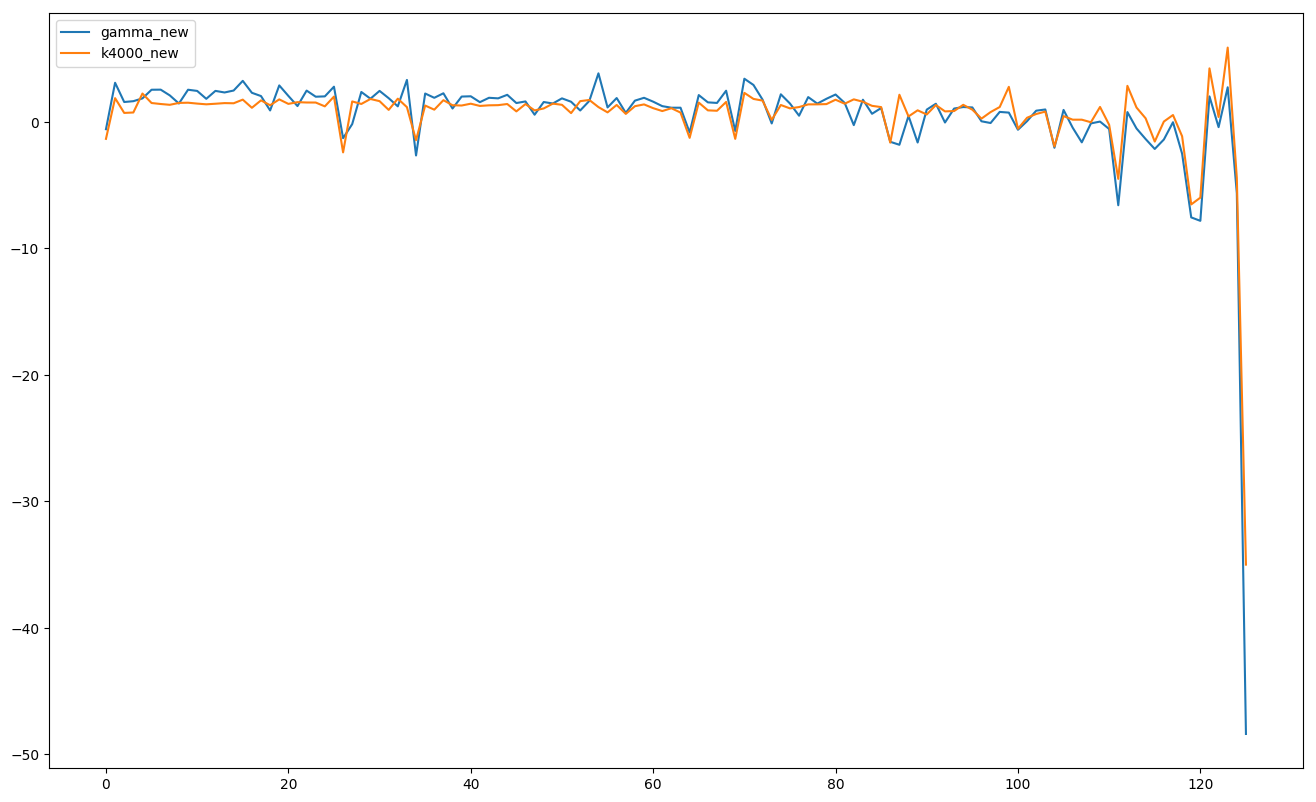

In [321]:
plt.plot(gamma_new, label="gamma_new")
plt.plot(k4000_new, label="k4000_new")
plt.legend()

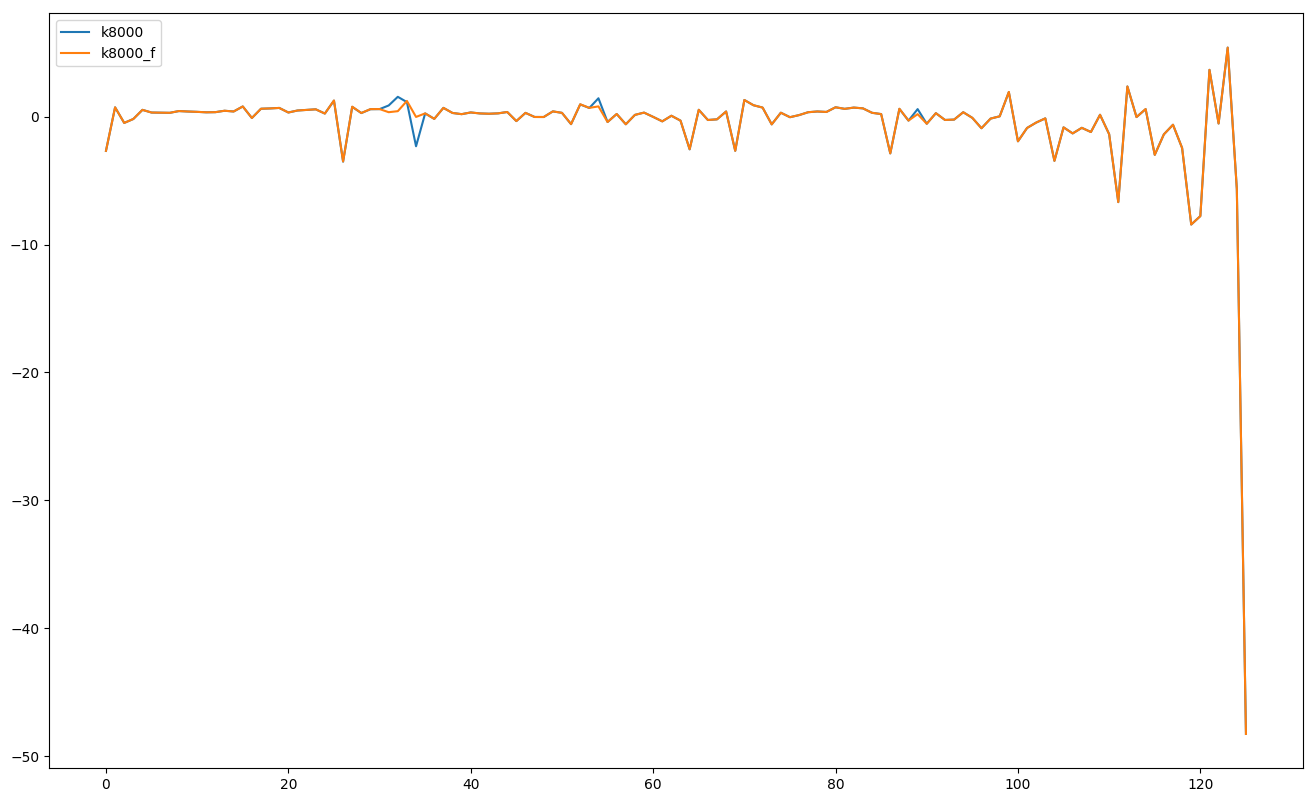

In [331]:
# plt.plot(np.linalg.inv(B).dot(A))
plt.plot(gamma_k8000, label="k8000")
# plt.plot(gamma_k8000_centered, label="k8000_center")
# plt.plot(gamma_new, label="gamma_new")
plt.plot(gamma_k8000_f, label="k8000_f")
# plt.plot(k4000_new, label="k4000_new")
plt.legend()

In [269]:
np.mean(gamma_k1000)

2.380952381144205e-07

In [270]:
np.mean(gamma_k4000)

-5.639228061588096e-17

In [268]:
np.mean(gamma_k8000)

-0.5763359523809523

In [303]:
np.where(np.abs(gamma_k8000_centered)> 2)[0]

array([  0,  26,  32,  54,  69,  86,  99, 104, 111, 112, 115, 119, 120,
       121, 123, 124, 125])

In [301]:
six_letter_code_combinations = ['000004', '000013', '000022', '000031', '000040', '000103', '000112', '000121', '000130', '000202', '000211', '000220', '000301', '000310', '000400', '001003', '001012', '001021', '001030', '001102', '001111', '001120', '001201', '001210', '001300', '002002', '002011', '002020', '002101', '002110', '002200', '003001', '003010', '003100', '004000', '010003', '010012', '010021', '010030', '010102', '010111', '010120', '010201', '010210', '010300', '011002', '011011', '011020', '011101', '011110', '011200', '012001', '012010', '012100', '013000', '020002', '020011', '020020', '020101', '020110', '020200', '021001', '021010', '021100', '022000', '030001', '030010', '030100', '031000', '040000', '100003', '100012', '100021', '100030', '100102', '100111', '100120', '100201', '100210', '100300', '101002', '101011', '101020', '101101', '101110', '101200', '102001', '102010', '102100', '103000', '110002', '110011', '110020', '110101', '110110', '110200', '111001', '111010', '111100', '112000', '120001', '120010', '120100', '121000', '130000', '200002', '200011', '200020', '200101', '200110', '200200', '201001', '201010', '201100', '202000', '210001', '210010', '210100', '211000', '220000', '300001', '300010', '300100', '301000', '310000', '400000']


In [307]:
six_letter_code_combinations = np.array(six_letter_code_combinations)

In [325]:
six_letter_code_combinations[np.where(gamma_k8000 > 2)]

array(['201010', '300010', '301000'], dtype='<U6')

In [326]:
six_letter_code_combinations[np.where(gamma_k8000 < -2)]

array(['000004', '002011', '004000', '022000', '040000', '102001',
       '130000', '201001', '210001', '211000', '220000', '300001',
       '310000', '400000'], dtype='<U6')

In [310]:
six_letter_code_combinations[np.where(gamma_k8000_centered > 2)]

array(['003010', '013000', '112000', '201010', '300010', '301000'],
      dtype='<U6')

In [311]:
six_letter_code_combinations[np.where(gamma_k8000_centered < -2)]

array(['000004', '002011', '040000', '102001', '130000', '201001',
       '210001', '220000', '300001', '310000', '400000'], dtype='<U6')

In [271]:
gamma_k8000_centered = gamma_k8000 - np.mean(gamma_k8000)

In [ ]:
gamma_cb

In [335]:
gamma_cb_centered = gamma_cb - np.mean(gamma_cb)

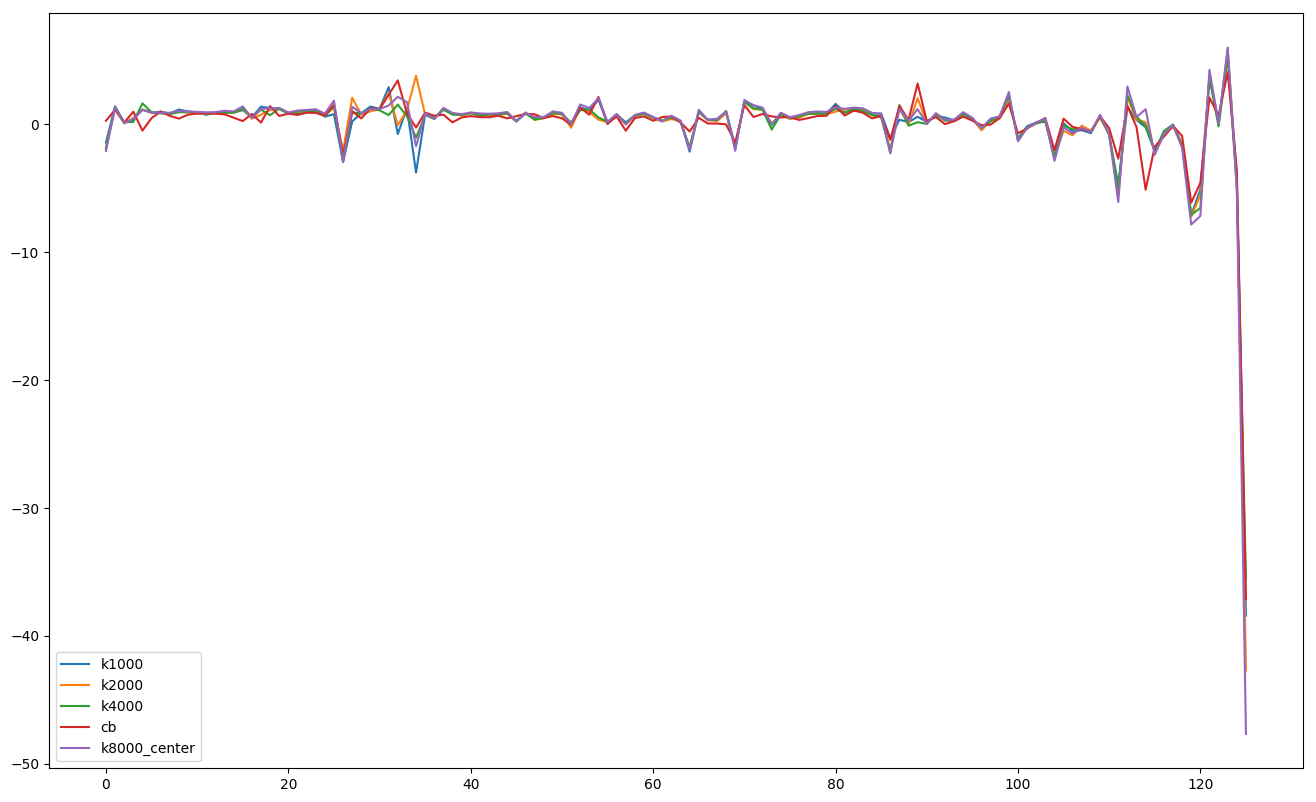

In [336]:
plt.plot(gamma_k1000, label="k1000")
plt.plot(gamma_k2000, label="k2000")
plt.plot(gamma_k4000, label="k4000")
plt.plot(gamma_cb_centered, label="cb")
# plt.plot(gamma_k8000, label="k8000")
plt.plot(gamma_k8000_centered, label="k8000_center")
# plt.plot(gamma_new, label="gamma_new")
plt.legend()

(-5, 5)

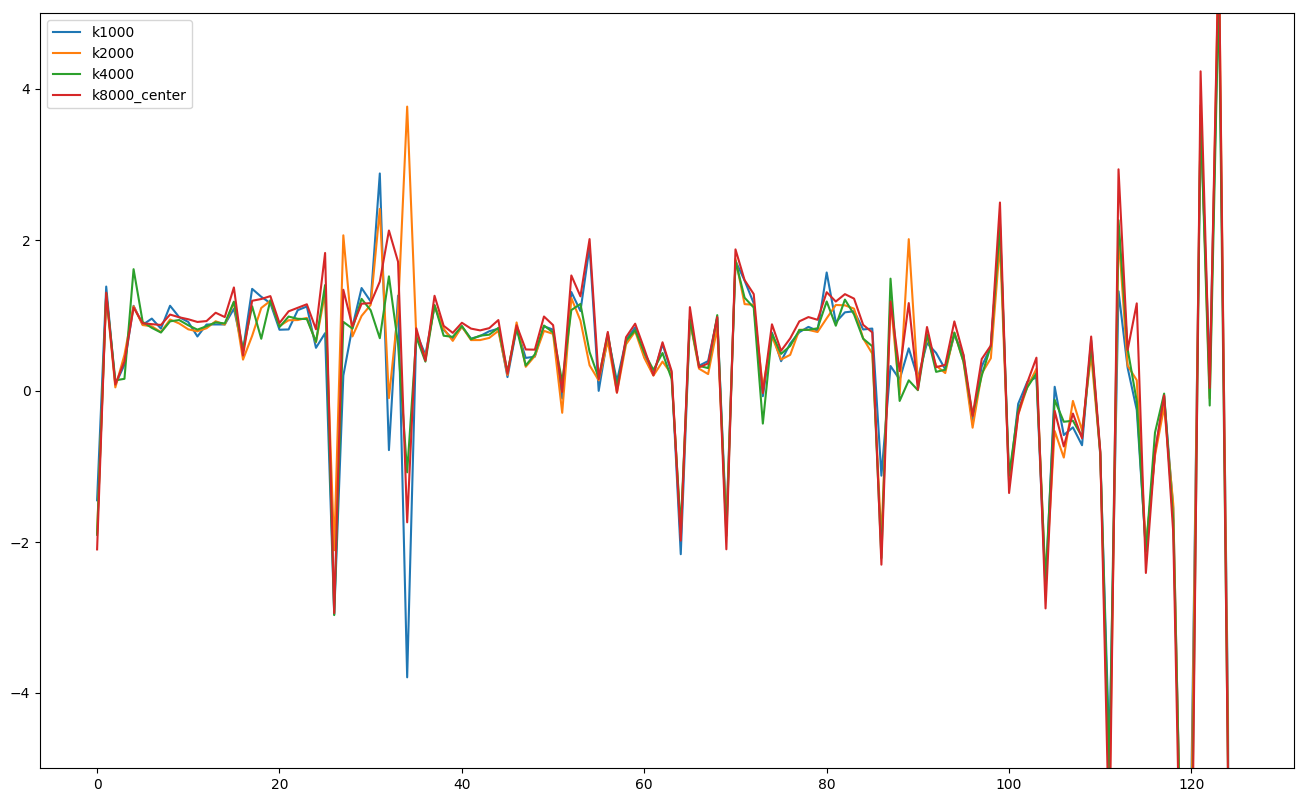

In [274]:
plt.plot(gamma_k1000, label="k1000")
plt.plot(gamma_k2000, label="k2000")
plt.plot(gamma_k4000, label="k4000")
# plt.plot(gamma_k8000, label="k8000")
plt.plot(gamma_k8000_centered, label="k8000_center")
plt.legend()
plt.ylim(-5,5)

(-5, 5)

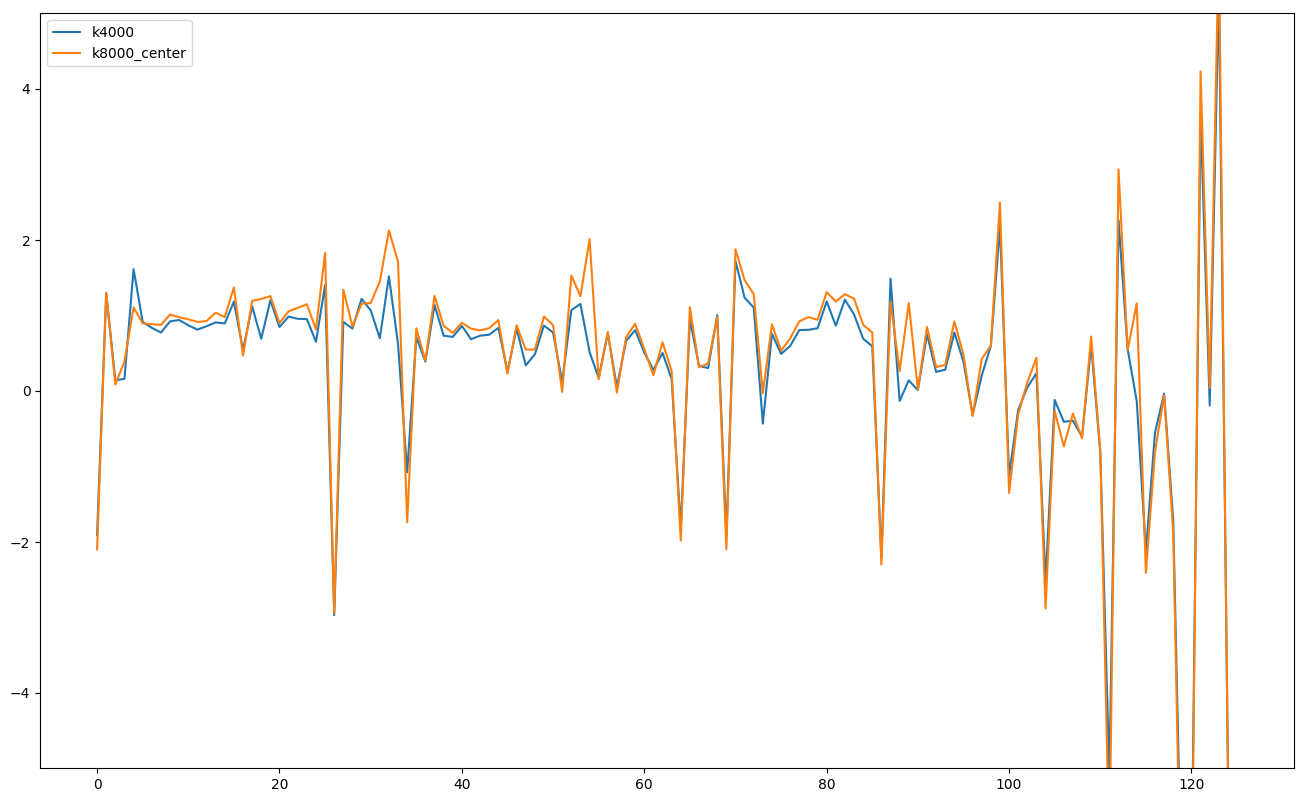

In [275]:
# plt.plot(gamma_k1000, label="k1000")
# plt.plot(gamma_k2000, label="k2000")
plt.plot(gamma_k4000, label="k4000")
# plt.plot(gamma_k8000, label="k8000")
plt.plot(gamma_k8000_centered, label="k8000_center")
plt.legend()
plt.ylim(-5,5)

In [341]:
import glob
a = glob.glob("/Users/weilu/Research/server/may_2019/four_body_helix_use_cb/optimization/data/*.dat")

In [357]:
d.split("/")[-1].split("-")[0]

'4rp9'

In [351]:
d = a[0]
tmp = pd.read_csv(d, sep=" ", names=["res_pair1_chain", "res_pair1_index_1", "res_pair1_index_2", 
                               "res_pair2_chain", "res_pair2_index_1", "res_pair2_index_2", 
                               "res_type",  "six_letter_string", "total_phi",
                              "d00", "d11", "d01", "d10"])


In [358]:
data_all = []
for d in a:
    name = d.split("/")[-1].split("-")[0]
    tmp = pd.read_csv(d, sep=" ", names=["res_pair1_chain", "res_pair1_index_1", "res_pair1_index_2", 
                               "res_pair2_chain", "res_pair2_index_1", "res_pair2_index_2", 
                               "res_type",  "six_letter_string", "total_phi",
                              "d00", "d11", "d01", "d10"])
    data_all.append(tmp.assign(protein=name))

In [359]:
data = pd.concat(data_all)
data = data.reset_index(drop=True)
data["six_letter_string"] = data["six_letter_string"].astype(str).str.pad(width=6, fillchar="0")

In [381]:
data.shape

(2973, 14)

In [382]:
data["six_letter_string"].value_counts()

020200    202
010300    160
010201    142
120100    139
110200    137
030100    116
020101    113
110101    109
010210     79
220000     77
130000     74
210100     74
120001     68
020110     64
000400     60
010111     58
010102     54
110110     54
100201     53
200200     45
120010     43
000301     42
040000     41
011200     40
210001     40
100300     40
200101     35
021100     34
030001     31
030010     31
         ... 
201001      5
011002      5
010030      4
100012      4
000022      4
010003      4
000112      4
000130      4
001111      3
200020      3
100021      2
011020      2
002101      2
022000      2
012001      2
001120      2
002011      2
001021      2
101011      2
300010      1
202000      1
000031      1
102100      1
102001      1
001003      1
000004      1
000040      1
100030      1
001012      1
012100      1
Name: six_letter_string, Length: 106, dtype: int64

In [367]:
data["res_type"].value_counts()

GGGG    9
AAGG    7
AGGG    7
GAGA    7
AGGA    6
AGAV    5
AGAG    5
GGAA    5
GGTA    5
GAAG    5
AAGA    5
FAGG    5
GLAL    5
LLAA    4
IAAG    4
AVAS    4
GAGY    4
IAIV    4
AAVG    4
AAAS    4
LLLI    4
AAIA    4
SSGG    3
AVLG    3
TAAG    3
GAVG    3
FGAS    3
AGTA    3
AATV    3
GAVT    3
       ..
FGVA    1
LELV    1
LLTL    1
IFTF    1
QFGT    1
FGCF    1
FLPF    1
AIHI    1
RAIA    1
QFSV    1
LAAN    1
ATPG    1
LGLF    1
VTQG    1
CLLA    1
ISKI    1
VIIL    1
APLS    1
GQGI    1
GSAV    1
PLSV    1
FLGA    1
IMSG    1
ALSA    1
FAGV    1
AYTL    1
VAWI    1
IGLA    1
GILT    1
SSVL    1
Name: res_type, Length: 2557, dtype: int64

In [363]:
data.groupby("protein").count()

,res_pair1_chain,res_pair1_index_1,res_pair1_index_2,res_pair2_chain,res_pair2_index_1,res_pair2_index_2,res_type,six_letter_string,total_phi,d00,d11,d01,d10
protein,,,,,,,,,,,,,
1j4n,74,74,74,74,74,74,74,74,74,74,74,74,74
1kpl,159,159,159,159,159,159,159,159,159,159,159,159,159
2c3e,50,50,50,50,50,50,50,50,50,50,50,50,50
2ksf,13,13,13,13,13,13,13,13,13,13,13,13,13
2lom,1,1,1,1,1,1,1,1,1,1,1,1,1
2lop,5,5,5,5,5,5,5,5,5,5,5,5,5
2mmu,2,2,2,2,2,2,2,2,2,2,2,2,2
2mpn,6,6,6,6,6,6,6,6,6,6,6,6,6
2q7r,7,7,7,7,7,7,7,7,7,7,7,7,7


In [180]:
pdb_list = ['6c70', '5azb', '4r1i', '6bvg', '4zr1', '5o5e', '6eu6', '4pgr']
for pdb in pdb_list:
    toLocation = pre + f"transmembrane/{pdb}.pdb"
    seq = getSeqFromPDB(toLocation)
    gxxxg_count = 0
    for i in range(len(seq)-4):
        if seq[i] == "G" and seq[i+4] == "A" and " " not in seq[i:i+4]:
            gxxxg_count += 1
            print(pdb, "Found GXXXG", i, seq[i:i+5])

6c70 Found GXXXG 87 GHVFA
5azb Found GXXXG 22 GFIFA
4r1i Found GXXXG 58 GVGIA
4r1i Found GXXXG 86 GGYSA
4r1i Found GXXXG 136 GLIWA
4r1i Found GXXXG 256 GSASA
6bvg Found GXXXG 62 GGSWA
6bvg Found GXXXG 71 GGAFA
6bvg Found GXXXG 72 GAFAA
6bvg Found GXXXG 109 GFLGA
6bvg Found GXXXG 164 GRWIA
6bvg Found GXXXG 236 GSTAA
6bvg Found GXXXG 266 GLAFA
5o5e Found GXXXG 48 GALLA
5o5e Found GXXXG 175 GMTFA
6eu6 Found GXXXG 117 GGWFA
6eu6 Found GXXXG 256 GVIVA
4pgr Found GXXXG 84 GTIGA


In [181]:
for pdb in pdb_list:
    toLocation = pre + f"transmembrane/{pdb}.pdb"
    seq = getSeqFromPDB(toLocation)
    gxxxg_count = 0
    for i in range(len(seq)-4):
        if seq[i] == "G" and seq[i+4] == "G" and " " not in seq[i:i+4]:
            gxxxg_count += 1
            print(pdb, "Found GXXXG", i, seq[i:i+5])

5azb Found GXXXG 38 GVFLG
5azb Found GXXXG 42 GGRIG
5azb Found GXXXG 75 GGLIG
5azb Found GXXXG 97 GLGAG
5azb Found GXXXG 109 GELWG
4r1i Found GXXXG 83 GVSGG
4r1i Found GXXXG 174 GIVYG
6bvg Found GXXXG 28 GKLIG
6bvg Found GXXXG 101 GVFVG
6bvg Found GXXXG 105 GIITG
6bvg Found GXXXG 232 GQVIG
4zr1 Found GXXXG 116 GFAGG
4zr1 Found GXXXG 119 GGLFG
5o5e Found GXXXG 23 GVISG
5o5e Found GXXXG 122 GLEAG
6eu6 Found GXXXG 143 GFNGG
6eu6 Found GXXXG 205 GLITG
6eu6 Found GXXXG 232 GGVIG
4pgr Found GXXXG 14 GLFIG


In [193]:
for pdb in pdb_list:
    toLocation = pre + f"transmembrane/{pdb}.pdb"
    seq = getSeqFromPDB(toLocation, considerGap=False)
    gxxxg_count = 0
    for i in range(len(seq)-4):
        if seq[i] == "G" and seq[i+4] == "G" and " " not in seq[i:i+4]:
            gxxxg_count += 1
            print(pdb, "Found GXXXG", i, seq[i:i+5])

5azb Found GXXXG 37 GVFLG
5azb Found GXXXG 41 GGRIG
5azb Found GXXXG 74 GGLIG
5azb Found GXXXG 94 GLGAG
5azb Found GXXXG 106 GELWG
4r1i Found GXXXG 75 GVSGG
4r1i Found GXXXG 163 GIVYG
4r1i Found GXXXG 206 GIAKG
6bvg Found GXXXG 27 GKLIG
6bvg Found GXXXG 94 GVFVG
6bvg Found GXXXG 98 GIITG
6bvg Found GXXXG 197 GTVAG
6bvg Found GXXXG 217 GQVIG
4zr1 Found GXXXG 108 GFAGG
4zr1 Found GXXXG 111 GGLFG
5o5e Found GXXXG 22 GVISG
5o5e Found GXXXG 115 GLEAG
6eu6 Found GXXXG 135 GFNGG
6eu6 Found GXXXG 194 GLITG
6eu6 Found GXXXG 219 GGVIG
4pgr Found GXXXG 14 GLFIG


In [217]:
for pdb in pdb_list:
    toLocation = pre + f"transmembrane/{pdb}.pdb"
    seq,resSeqs = getSeqFromPDB(toLocation, considerGap=True)
    gxxxg_count = 0
    for i in range(len(seq)-4):
        if seq[i] == "G" and seq[i+4] == "G" and " " not in seq[i:i+4]:
            gxxxg_count += 1
            print(pdb, "Found GXXXG", i, seq[i:i+5], "Residue", resSeqs[i])

5azb Found GXXXG 39 GVFLG Residue 65
5azb Found GXXXG 43 GGRIG Residue 69
5azb Found GXXXG 76 GGLIG Residue 102
5azb Found GXXXG 98 GLGAG Residue 136
5azb Found GXXXG 110 GELWG Residue 148
4r1i Found GXXXG 84 GVSGG Residue 169
4r1i Found GXXXG 175 GIVYG Residue 318
6bvg Found GXXXG 28 GKLIG Residue 29
6bvg Found GXXXG 101 GVFVG Residue 138
6bvg Found GXXXG 105 GIITG Residue 142
6bvg Found GXXXG 232 GQVIG Residue 305
4zr1 Found GXXXG 117 GFAGG Residue 195
4zr1 Found GXXXG 120 GGLFG Residue 198
5o5e Found GXXXG 24 GVISG Residue 52
5o5e Found GXXXG 123 GLEAG Residue 171
6eu6 Found GXXXG 144 GFNGG Residue 222
6eu6 Found GXXXG 206 GLITG Residue 296
6eu6 Found GXXXG 233 GGVIG Residue 329
4pgr Found GXXXG 15 GLFIG Residue 25


In [198]:
location = pre + f"transmembrane/5azb.pdb"

In [199]:
x = PDBParser().get_structure("x", location)

In [202]:
list(x.get_residues())[37].get_id()[1]

65

In [209]:
resseqs = [res.get_id()[1] for res in x.get_residues()]

In [211]:
resseqs[37]

65

In [195]:
toLocation

'/Users/weilu/Research/database/membrane_training_set/transmembrane/4pgr.pdb'

In [187]:
print(pdb_list)

['6c70', '5azb', '4r1i', '6bvg', '4zr1', '5o5e', '6eu6', '4pgr']


In [190]:
with open("/Users/weilu/Research/server/may_2019/four_body_helix/optimization/protein_list", "w") as out:
    for pdb in pdb_list:
        print(pdb)
        out.write(pdb+"\n")

6c70
5azb
4r1i
6bvg
4zr1
5o5e
6eu6
4pgr


In [192]:
for pdb in pdb_list:
    location = f"/Users/weilu/Research/server/may_2019/four_body_helix/database/dompdb/{pdb}.pdb"
    toLocation = f"/Users/weilu/Research/server/may_2019/four_body_helix/database/S20_seq/{pdb}.seq"
    seq = getSeqFromPDB(location, considerGap=False)
    with open(toLocation, "w") as out:
        out.write(seq+'\n')

In [64]:
x = PDBParser().get_structure("x", "/Users/weilu/Research/database/membrane_training_set/cleaned_pdbs/6c70.pdb")

In [88]:
seq = getSeqFromPDB("/Users/weilu/Research/database/membrane_training_set/transmembrane/gly_only.pdb")

In [136]:
seq = getSeqFromPDB("/Users/weilu/Research/database/")
gxxxg_count = 0
for i in range(len(seq)):
    if seq[i] == "G" and seq[i+4] == "G" and " " not in seq[i:i+4]:
        gxxxg_count += 1
        print("Found GXXXG", i, seq[i:i+5])

Found GXXXG 257 GDAYG


In [129]:
location = "/Users/weilu/Research/database/membrane_training_set/cleaned_pdbs/6c70.pdb"
location = "/Users/weilu/Research/database/membrane_training_set/transmembrane/gly_only.pdb"
x = PDBParser().get_structure("x", location)
ppb=CaPPBuilder()
seq = ""

In [130]:
list(ppb.build_peptides(x))

[<Polypeptide start=16 end=17>,
 <Polypeptide start=19 end=23>,
 <Polypeptide start=35 end=59>,
 <Polypeptide start=68 end=90>,
 <Polypeptide start=132 end=150>,
 <Polypeptide start=158 end=164>,
 <Polypeptide start=173 end=196>,
 <Polypeptide start=263 end=284>,
 <Polypeptide start=288 end=311>,
 <Polypeptide start=362 end=363>,
 <Polypeptide start=367 end=387>]

In [131]:
seq = ""
preResId = 0
for res in x.get_residues():
    resId = res.get_id()[1]
    if resId != preResId + 1:
        seq += " "
    seq += three_to_one(res.get_resname())
    preResId = resId

In [135]:
getSeqFromPDB(location)

'VM GVGHF PHRIYCIVTLLLLLLQYGMMAVNLM LTANTITMLFFLHPIVKMIYFPV CVAGATIFSVISWTGITFI LMIRTFY GHVFALIYQFYYLVISMAVSNSLD VALLLHMLTTTITLTLLAYQAT V GVNVYAATVIGYLLYTLGQVFLFC G FF LDLFASVLGAVVTYFMVLVQL'

In [133]:
seq.strip()

'VM GVGHF PHRIYCIVTLLLLLLQYGMMAVNLM LTANTITMLFFLHPIVKMIYFPV CVAGATIFSVISWTGITFI LMIRTFY GHVFALIYQFYYLVISMAVSNSLD VALLLHMLTTTITLTLLAYQAT V GVNVYAATVIGYLLYTLGQVFLFC G FF LDLFASVLGAVVTYFMVLVQL'

In [125]:
res.get_id()[1]

388

In [121]:
three_to_one(res.get_resname())

'K'

In [118]:
from Bio.PDB.Polypeptide import three_to_one

In [120]:
three_to_one("LYS")

'K'

In [116]:
res.get_id()[1]

388

In [112]:
res.full_id[2]

'A'

In [113]:
seq

'AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA'

In [98]:
aseq

'FKHQGLVADLLPNIRVMQGVGHFMFNYYSEGKKFPHRIYCIVTLLLLLLQYGMMAVNLMMESDDVDDLTANTITMLFFLHPIVKMIYFPVRSKIFYKTLAIWNNPNSHPLFAESNARFHALAITKMRRLLFCVAGATIFSVISWTGITFIEDS PIPRLMIRTFYPFNAMSGAGHVFALIYQFYYLVISMAVSNSLDVLFCSWLLFACEQLQHLKAIMKPLMELSAT GLTKKQEMLVRSAIKYWVERHKHVVRLVTAVGDAYGVALLLHMLTTTITLTLLAYQATKVNGVNVYAATVIGYLLYTLGQVFLFCIFGNRLIEESSSVMEAAYSCHWYDGSEEAKTFVQIVCQQCQKAMSISGAKFFTVSLDLFASVLGAVVTYFMVLVQLK'

In [99]:
for i in range(len(seq)):
    if seq[i] == " ":
        print(i)

153
227


In [90]:
gxxxg_count

0

In [96]:
def getSeqFromPDB(location, considerGap=True):
    x = PDBParser().get_structure("x", location)
    ppb=PPBuilder()
    seq = ""
    for pp in ppb.build_peptides(x):
        if considerGap:
            seq += " " + str(pp.get_sequence())
        else:
            seq += str(pp.get_sequence())
    return seq.strip()

In [82]:
len(seq)

388

In [72]:
a = app.get_sequence()

In [70]:
str(pp.get_sequence())

'GLTKKQEMLVRSAIKYWVERHKHVVRLVTAVGDAYGVALLLHMLTTTITLTLLAYQATKVNGVNVYAATVIGYLLYTLGQVFLFCIFGNRLIEESSSVMEAAYSCHWYDGSEEAKTFVQIVCQQCQKAMSISGAKFFTVSLDLFASVLGAVVTYFMVLVQLK'

In [41]:
res = list(x.get_residues())[0]

In [42]:
ca = res["CA"]

In [45]:
if abs(ca.get_vector()[-1]) > 15

SyntaxError: invalid syntax (<ipython-input-45-4d008d927f5f>, line 1)

In [46]:
from Bio.PDB.PDBIO import PDBIO

In [53]:
pre = "/Users/weilu/Research/database/membrane_training_set/transmembrane/"

In [54]:
from Bio.PDB.PDBIO import Select

In [55]:
class Transmembrane(Select):
    def accept_residue(self, residue):
        if abs(residue["CA"].get_vector()[-1]) < 15:
            return 1
        else:
            return 0

io = PDBIO()
io.set_structure(x)
io.save(pre + 'gly_only.pdb', Transmembrane())

In [56]:
res.get_id()

(' ', 1, ' ')

In [57]:
x = PDBParser().get_structure("x", pre + 'gly_only.pdb')

In [58]:
res = list(x.get_residues())[50]

In [59]:
res.get_id()

(' ', 86, ' ')